In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

In [2]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
import warnings
warnings.filterwarnings('ignore')

# Imputing with KNNImputer
from sklearn.impute import KNNImputer

In [3]:
df = pd.read_csv('home_date_miss_values.csv', sep=';')
df['date'] = pd.to_datetime(df['date'])
df = df[df.date > pd.to_datetime('2022-05-30')]
df

,date,value
731,2022-05-31,31183.7
732,2022-06-01,29328.6
733,2022-06-02,29572.8
734,2022-06-03,29255.0
735,2022-06-04,29450.1
...,...,...
1091,2023-05-26,26338.0
1092,2023-05-27,26554.8
1093,2023-05-28,26788.7
1094,2023-05-29,27550.0


# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 731 to 1095
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    365 non-null    datetime64[ns]
 1   value   353 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.6 KB


In [5]:
df.describe()

,date,value
count,365,353.000000
mean,2022-11-29 00:00:00.000000256,21839.537677
min,2022-05-31 00:00:00,15470.500000
25%,2022-08-30 00:00:00,18937.300000
50%,2022-11-29 00:00:00,20957.000000
75%,2023-02-28 00:00:00,24210.800000
max,2023-05-30 00:00:00,31183.700000
std,NaN,4040.851138


In [6]:
df.value

731     31183.7
732     29328.6
733     29572.8
734     29255.0
735     29450.1
         ...   
1091    26338.0
1092    26554.8
1093    26788.7
1094    27550.0
1095    27559.8
Name: value, Length: 365, dtype: float64

In [7]:
df = df.ffill()
df

,date,value
731,2022-05-31,31183.7
732,2022-06-01,29328.6
733,2022-06-02,29572.8
734,2022-06-03,29255.0
735,2022-06-04,29450.1
...,...,...
1091,2023-05-26,26338.0
1092,2023-05-27,26554.8
1093,2023-05-28,26788.7
1094,2023-05-29,27550.0


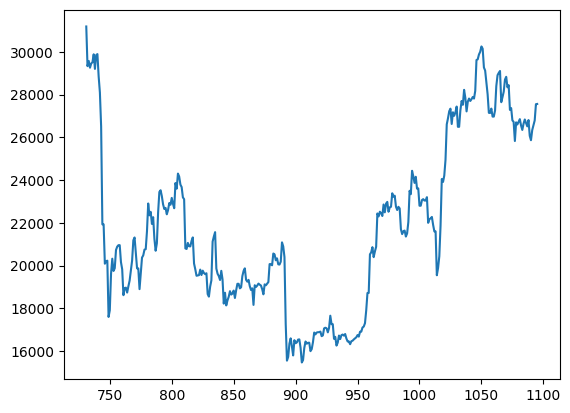

In [8]:
plt.plot(df['value'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 731 to 1095
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    365 non-null    datetime64[ns]
 1   value   365 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.6 KB


In [10]:
train_df = df[df.date < pd.to_datetime('2023-05-01')]
test_df = df[df.date >= pd.to_datetime('2023-05-01')]
print(train_df.shape)
print(test_df.shape)

(335, 2)
(30, 2)


In [11]:
# Проверка на стационарность
result = adfuller(df['value'])
print('ADF Statistic:', result[0])
print('p-value:', result[1]) # p-value > 0.05
print('Critical Values:', result[4]) # Critical Values < ADF Statistic

ADF Statistic: -1.9621771140607298
p-value: 0.3033992684750788
Critical Values: {'1%': -3.448493650810824, '5%': -2.8695352280356556, '10%': -2.5710293341377715}


In [62]:
# Moving Avarage
AR = ARIMA(train_df.value.values, order=(3,0,20)) # rmse = 760 
#SimpleExpSmoothing(train_df.value.values) # rmse = 2200
#SARIMAX(train_df.value.values, order=(4,1,20), seasonal= (1,1,1,1)) # rmse = 1900
#ARIMA(train_df.value.values, order=(4,1,20)) # rmse = 1900
#AutoReg(train_df.value.values, lags=11) # rmse = 970
AR_model = AR.fit()

In [63]:
AR_model.predict(start=len(train_df),
                 end=len(train_df) + len(test_df)-1)

array([28871.49894715, 29066.39085899, 28841.81504603, 28492.47883477,
       28320.82106913, 28070.00309154, 27848.87677862, 27620.16394413,
       27644.28846966, 27560.67233971, 27569.88848237, 27505.43020018,
       27315.70326504, 27410.34437688, 27465.13712317, 27350.96893912,
       27247.47025207, 27145.56706134, 27031.28340577, 26920.07454761,
       26813.65064014, 26711.78370963, 26613.7718554 , 26518.93259934,
       26426.73042225, 26336.77909139, 26248.81007457, 26162.63873955,
       26078.13727595, 25995.21526946])

In [64]:
test_df['AR_model_prediction'] = AR_model.predict(start =len(train_df),
                                                  end= len(train_df) + len(test_df)-1)

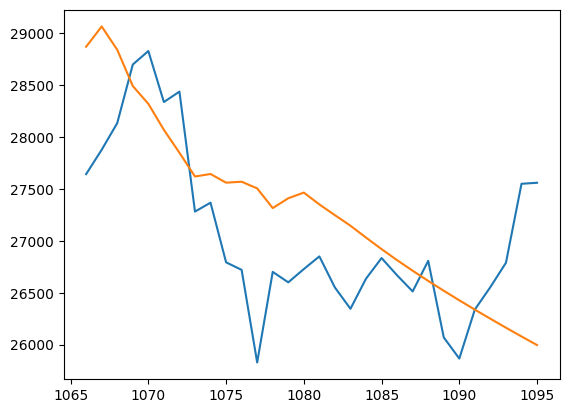

In [65]:
plt.plot(test_df[['value', 'AR_model_prediction']])

In [66]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print('MAE MA_model: ', mean_absolute_error(test_df['value'],
                                            test_df['AR_model_prediction']))

print('RMSE MA_model: ', mean_squared_error(test_df['value'],
                                            test_df['AR_model_prediction'])**0.5)


MAE MA_model:  625.7154183388768
RMSE MA_model:  759.3398382061091
